# Dipping your toe in the ocean of Computer Vision
### Using Keras and OpenCV

In [1]:
# NumPy - math library for handling matrices and arrays
import numpy as np

# MNIST dataset containing over 60 000 training and 10 000 test examples
from keras.datasets import mnist 

# Keras is Tensorflow's high level API for Deep Learning
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten

# Matplotlib's PyPlot - visualization library
import matplotlib.pyplot as plt

# OpenCV - Opensource Computer Vision library
import cv2 as cv

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

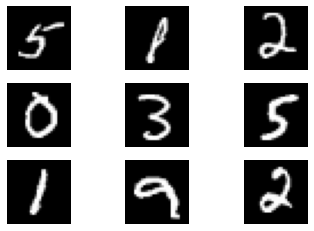

In [51]:
from random import choice

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(x_train[choice(range(len(x_train)))], cmap='gray')

plt.show()

In [4]:
x_train[0].shape

(28, 28)

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [6]:
x_train[0].shape

(28, 28, 1)

In [7]:
def normalize(data): 
    # Normalize data from the range of (0 --> 255) to (0.0 --> 1.0) which accelrates training
    data = data.astype('float32')
    data /= 255
    return data

In [8]:
x_train = normalize(x_train)
x_test = normalize(x_test)

In [9]:
y_train.shape

(60000,)

In [10]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [11]:
y_train.shape

(60000, 10)

In [13]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [56]:
number = np.where(y_train[0] == 1)
# returns a tuple of arrays, needs to enter tuple, and extract the 0'the index  
number[0][0] 

5

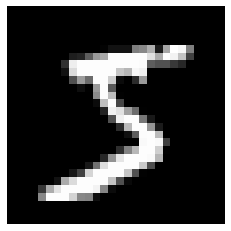

In [59]:
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')
plt.show()

## Let's define a model

In [17]:
model = Sequential() 

model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

## Interactive Node-Link Visualization of:
### [Fully Connected Neural Networks](https://www.cs.ryerson.ca/~aharley/vis/fc/)

### [Convolutional Neural Networks](https://www.cs.ryerson.ca/~aharley/vis/conv/)

In [18]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=32,
    verbose=1
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'loss'], loc='best')
plt.show()

"\nhistory = model.fit(\n    x_train,\n    y_train,\n    epochs=30,\n    batch_size=32,\n    verbose=1\n)\n\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['loss'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['training', 'loss'], loc='best')\nplt.show()\n"

In [20]:
model.save_weights('models/my_first_model.h5')

In [21]:
model.load_weights('models/simple_fnn_30_epochs.h5')

In [22]:
loss, accuracy  = model.evaluate(x_test, y_test, verbose=True)

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

313/313 [==============================] - 0s 501us/step - loss: 0.1201 - accuracy: 0.9806
Test loss: 0.12
Test accuracy: 0.981


In [23]:
score = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 511us/step - loss: 0.1201 - accuracy: 0.9806


## Let's have some fun

In [ ]:
import math
from scipy import ndimage


def get_best_shift(img):
    center_y , center_x = ndimage.measurements.center_of_mass(img)

    rows, cols = img.shape
    shift_y = np.round(rows//2 - center_y)
    shift_x = np.round(cols//2 - center_x)

    return shift_x, shift_y


def shift(img, sx, sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv.warpAffine(img,M,(cols,rows))
    return shifted


def mnist_preprocessing(image, dim=28, box=20):
    resized_image = cv.resize(image, dsize=(dim, dim), interpolation=cv.INTER_LINEAR)
    gray = np.asarray(cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY))
    gray = 255 - gray
    gray = cv.resize(gray, (dim, dim))
    _, thresh = cv.threshold(gray, 128, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray, 0, 1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray, -1, 1)

    rows,cols = gray.shape

    if rows > cols:
        factor = box/rows
        rows = box
        cols = int(round(cols*factor))
        gray = cv.resize(gray, (cols,rows))
    else:
        factor = box/cols
        cols = box
        rows = int(round(rows*factor))
        gray = cv.resize(gray, (cols, rows))

    colsPadding = (int(math.ceil((dim - cols)/2.0)),int(math.floor((dim - cols)/2.0)))
    rowsPadding = (int(math.ceil((dim - rows)/2.0)),int(math.floor((dim - rows)/2.0)))
    gray = np.pad(gray, (rowsPadding, colsPadding), 'constant')

    shiftx,shifty = get_best_shift(gray)
    shifted = shift(gray,shiftx,shifty)
    
    normalized_img = normalize(shifted)
    
    return shifted

In [34]:
def predict_single_image(model, img):
    img = np.expand_dims(img, axis=0)     # --> (1, 28, 28)
    img = np.reshape(img, [1, 28, 28, 1]) # --> (1, 28, 28, 1)
    pred = model.predict(img)
    label = np.argmax(pred[:1])
    confidence = (pred[0][label])[0]*100
    
    return label, confidence

In [ ]:
# OpenCV - Opensource Computer Vision library
import cv2 as cv
import numpy as np
cap = cv.VideoCapture(0) 

init_frame_read_correctly, init_frame = cap.read()
if not init_frame_read_correctly:
        print("No frames to read...")
        

bounding_box = (init_frame.shape[1]//4, init_frame.shape[0]//4,
                init_frame.shape[1]//2, init_frame.shape[0]//2)    

while(cap.isOpened()):
    # Capture frame-by-frame
    frame_read_correctly, frame = cap.read()
    if not frame_read_correctly:
        print("No frames to read...")
        break
    
    
    # new_bounding_box = bounding_box
    wh = (frame.shape[1]//frame.shape[0])*200
    if frame_read_correctly:
        point1 = (frame.shape[1]//2 - wh, frame.shape[0]//2 - wh)
        point2 = (frame.shape[1]//2 + wh, frame.shape[0]//2 + wh)
        cv.rectangle(frame, point1, point2, (255, 255, 0), 2)
        

    try:
        # Crop out new ROI and process it
        new_ROI = frame[frame.shape[0]//2 - wh :frame.shape[0]//2 + wh, frame.shape[1]//2 - wh:frame.shape[1]//2 + wh]
        img = mnist_preprocessing(new_ROI)
        label, conf = predict_single_image(model, img)

        cv.namedWindow('processed', 0)
        cv.imshow('processed', img)
        
    except Exception as e:
        print(f"Exception occured:\n{e}")
        pass

    
    # Display the resulting pred
    cv.putText(frame,
               f"{label[0]}",
               org=(point2[0] - 75, point2[1] + 75),
               fontFace=cv.FONT_HERSHEY_PLAIN,
               fontScale=5,
               color=(255, 255, 0),
               thickness=2,
               lineType=cv.LINE_AA
              )
    
    cv.flip(frame, 1)
    cv.namedWindow('frame', 0)
    cv.resizeWindow('frame', 640, 480)
    cv.imshow('frame', frame)
    #cv.imshow('box', new_ROI)
    
    # Listen for keypress
    k = cv.waitKey(1)
    if (k & 0xFF == ord('q')) or (k % 256 == 27):
        break
    

# Release the capture afterward
cap.release()
cv.destroyAllWindows()